<a href="https://colab.research.google.com/github/janputra/RESNET/blob/main/RESNET50_(CIFAR_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, BatchNormalization,Activation, Add 
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import ZeroPadding2D, AveragePooling2D
from sklearn.model_selection import train_test_split 

In [ ]:
cifar10= tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test)= cifar10.load_data()
x_train, x_test=x_train/255.0, x_test/255.0
y_train, y_test= y_train.flatten(), y_test.flatten()
print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)

x_train shape : (50000, 32, 32, 3)
y_train shape : (50000,)


In [ ]:
K= len(set(y_train))
print('Number of Class : ',K)

Number of Class :  10


In [ ]:
train_im, valid_im, train_lab, valid_lab = train_test_split(x_train, y_train, test_size=0.20,  
                                                            random_state=40, shuffle = True)
print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

train data shape after the split:  (40000, 32, 32, 3)
new validation data shape:  (10000, 32, 32, 3)
validation labels shape:  (10000,)


In [ ]:
def resnet_conv(x, s, filters):
  x_skip = x
  f1,f2= filters

  x= Conv2D(f1,kernel_size=(1,1), strides=(s,s),padding='valid',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)
  x=Activation(activations.relu)(x)

  x= Conv2D(f1,kernel_size=(3,3), strides=(1,1),padding='same',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)
  x=Activation(activations.relu)(x)

  x= Conv2D(f2,kernel_size=(1,1), strides=(1,1),padding='valid',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)

  x_skip= Conv2D(f2,kernel_size=(1,1), strides=(s,s),padding='valid',kernel_regularizer=l2(0.001))(x_skip)
  x_skip=BatchNormalization()(x_skip)


  x=Add()([x,x_skip])
  x=Activation(activations.relu)(x)

  return x

In [ ]:
def resnet_identity(x, filters):
  x_skip = x
  f1,f2= filters

  x= Conv2D(f1,kernel_size=(1,1), strides=(1,1),padding='valid',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)
  x=Activation(activations.relu)(x)

  x= Conv2D(f1,kernel_size=(3,3), strides=(1,1),padding='same',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)
  x=Activation(activations.relu)(x)

  x= Conv2D(f2,kernel_size=(1,1), strides=(1,1),padding='valid',kernel_regularizer=l2(0.001))(x)
  x=BatchNormalization()(x)

  x=Add()([x,x_skip])
  x=Activation(activations.relu)(x)

  return x

In [ ]:
def resnet50():
  input_im = Input(shape=x_train[0].shape)
  x= ZeroPadding2D(padding=(3, 3))(input_im)

  x= Conv2D(64,kernel_size=(7,7), strides=(2,2))(x)
  x= BatchNormalization()(x)
  x=Activation(activations.relu)(x)
  x=MaxPooling2D((3,3),strides=(2,2))(x)

  x= resnet_conv(x,s=1,filters=(64,256))
  x= resnet_identity(x,filters=(64,256))
  x= resnet_identity(x,filters=(64,256))
    
  x= resnet_conv(x,s=2,filters=(128,512))
  x= resnet_identity(x,filters=(128,512))
  x= resnet_identity(x,filters=(128,512))
  x= resnet_identity(x,filters=(128,512))

  x= resnet_conv(x,s=2,filters=(256,1024))
  x= resnet_identity(x,filters=(256,1024))
  x= resnet_identity(x,filters=(256,1024))
  x= resnet_identity(x,filters=(256,1024))
  x= resnet_identity(x,filters=(256,1024))
  x= resnet_identity(x,filters=(256,1024))
 
  x= resnet_conv(x,s=2,filters=(512,2048))
  x= resnet_identity(x,filters=(512,2048))
  x= resnet_identity(x,filters=(512,2048))

  x= AveragePooling2D((2,2),padding='same')(x)

  x= Flatten()(x)
  x=Dense(K, activation='softmax',kernel_initializer='he_normal')(x)

  model = Model(inputs= input_im, outputs= x, name='Resnet50')
  return model

In [ ]:
model= resnet50()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
batch_size = 128
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(train_im, train_lab, batch_size)
steps_per_epoch = train_im.shape[0] // batch_size
print(steps_per_epoch)
r = model.fit(train_generator, validation_data=(valid_im, valid_lab), steps_per_epoch=steps_per_epoch, epochs=150)

312
Epoch 1/150
312/312 [==============================] - 83s 194ms/step - loss: 16.1773 - accuracy: 0.3644 - val_loss: 13.2433 - val_accuracy: 0.1666
Epoch 2/150
312/312 [==============================] - 58s 185ms/step - loss: 10.0896 - accuracy: 0.4542 - val_loss: 7.9955 - val_accuracy: 0.4818
Epoch 3/150
312/312 [==============================] - 56s 178ms/step - loss: 6.9201 - accuracy: 0.4747 - val_loss: 7.3096 - val_accuracy: 0.2080
Epoch 4/150
312/312 [==============================] - 55s 178ms/step - loss: 5.7387 - accuracy: 0.4630 - val_loss: 5.7734 - val_accuracy: 0.2454
Epoch 5/150
312/312 [==============================] - 55s 177ms/step - loss: 4.6794 - accuracy: 0.4765 - val_loss: 4.4784 - val_accuracy: 0.3552
Epoch 6/150
312/312 [==============================] - 58s 184ms/step - loss: 4.6741 - accuracy: 0.4458 - val_loss: 4.3025 - val_accuracy: 0.3623
Epoch 7/150
312/312 [==============================] - 55s 176ms/step - loss: 3.6433 - accuracy: 0.4945 - val_loss: 3

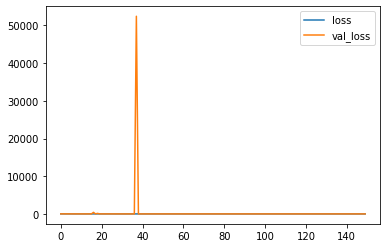

In [ ]:
hist =r.history

plt.plot(hist['loss'],label='loss')
plt.plot(hist['val_loss'],label='val_loss')
plt.legend()

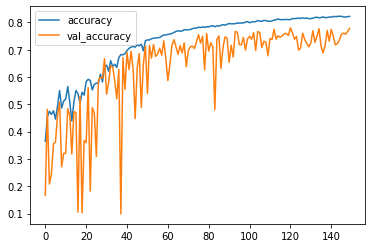

In [ ]:
plt.plot(hist['accuracy'],label='accuracy')
plt.plot(hist['val_accuracy'],label='val_accuracy')
plt.legend()

Confusion matrix, without normalization
[[687  20  70  40  25   7  29   7  55  60]
 [  6 891   3   3   2  11  18   1   6  59]
 [ 25   2 666  38  74  73  92  20   7   3]
 [  5   3  33 605  50 158 120  14   7   5]
 [  8   1  29  57 746  24 103  23   5   4]
 [  4   0  20 125  40 720  72  12   5   2]
 [  3   2  19  25  10  16 921   1   2   1]
 [  5   5  22  46  53 104  38 714   2  11]
 [ 44  30  12  11   7   2  19   2 843  30]
 [  4  58   6  11   2  11  20   0  13 875]]


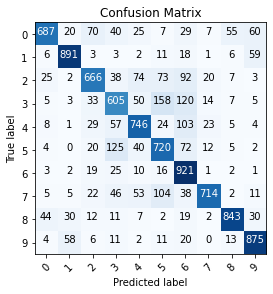

In [ ]:
#confussion matrix

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):


  if normalize:
    cm= cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  print(cm)


  plt.imshow(cm, interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar
  tick_marks= np.arange(len(classes))

  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt ='.2f' if normalize else 'd'

  thresh = cm.max()/2


  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
      plt.text(j,i,format(cm[i,j],fmt),
               horizontalalignment='center',
               color='white' if cm[i,j]>thresh else 'black')
      
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

  plt.show()


p_test=model.predict(x_test).argmax(axis=1)
cm= confusion_matrix(y_test, p_test)

plot_confusion_matrix(cm,list(range(10)))

In [ ]:
result_test = model.evaluate(x_test,y_test,verbose=0)
print("Loss : ", result_test[0])
print("Accuracy : ",result_test[1])

Loss :  0.8929507732391357
Accuracy :  0.7667999863624573


In [ ]:
# label mapping
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()

Text(0.5, 1.0, 'True label : deer Predicted : cat')

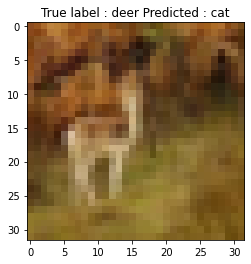

In [ ]:
#show misclassified examples

misclassified_idx= np.where(p_test!=y_test)[0]
i= np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap='gray')
plt.title('True label : %s Predicted : %s' % (labels[y_test[i]],labels[p_test[i]]))

In [ ]:
model.summary()

Model: "Resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
___________________________________________________________________________________________